In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
raw_data = pd.read_excel('momentum_data.xlsx',sheet_name = None)
sheets = list(raw_data.keys())
sheets

['descriptions',
 'factors (excess returns)',
 'momentum (excess returns)',
 'deciles (total returns)',
 'size_sorts (total returns)',
 'risk-free rate']

In [5]:
ff_factors = raw_data[sheets[1]].set_index('Date')
momentum = raw_data[sheets[2]].set_index('Date')
mom_deciles = raw_data[sheets[3]].set_index('Date')
tercile_port = raw_data[sheets[4]].set_index('Date')
rf = raw_data[sheets[5]].set_index('Date')

ff_factors['UMD'] = momentum['UMD']

## 2.1  Is momentum still profitable

(a) fill in table 1 with the appropriate stats 

In [6]:
def calc_summary_statistics(
    returns,
    annual_factor=12,
    provided_excess_returns=True,
    rf=None,
    var_quantile=0.05,
    **kwargs  # ignore unused args from original function
):
    """
    Simplified version: computes key summary statistics for returns.
    Compatible with code using [summary_col_names].
    """
    returns = returns.copy().astype(float)
    if not isinstance(returns.index, pd.DatetimeIndex):
        returns.index = pd.to_datetime(returns.index)
    
    # Basic stats
    summary = pd.DataFrame(index=returns.columns)
    summary['Mean'] = returns.mean()
    summary['Vol'] = returns.std()
    summary['Sharpe'] = summary['Mean'] / summary['Vol']
    summary['Annualized Mean'] = summary['Mean'] * annual_factor
    summary['Annualized Vol'] = summary['Vol'] * np.sqrt(annual_factor)
    summary['Annualized Sharpe'] = summary['Sharpe'] * np.sqrt(annual_factor)
    summary['Skewness'] = returns.skew()

    return summary

In [7]:
periods = [['1927', '2025'], ['1927', '1993'], ['1994', '2008'], ['2009', '2025']]
summary_col_names = ['Annualized Mean','Annualized Vol','Annualized Sharpe','Skewness']
res = []
for period in periods:
    temp = momentum.loc[period[0]:period[1]]
    temp_ff = ff_factors.loc[period[0]:period[1]]
    summary = calc_summary_statistics(temp, annual_factor=12, provided_excess_returns=True)[summary_col_names]
    summary['mkt_corr'] = temp_ff.corr().loc['MKT',['UMD']]
    summary['val_corr'] = temp_ff.corr().loc['HML',['UMD']]
    summary = summary.T.iloc[:,0].rename(f'{period[0]} - {period[1]}')
    res.append(summary)
summary  = pd.concat(res, axis=1).T
summary.style.format('{:.1%}')

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
1927 - 2025,7.3%,16.2%,45.0%,-306.2%,-34.8%,-41.0%
1927 - 1993,8.8%,16.1%,54.9%,-391.1%,-36.7%,-50.1%
1994 - 2008,10.3%,17.5%,58.6%,-59.6%,-24.0%,-12.0%
2009 - 2025,-1.4%,15.6%,-9.0%,-267.6%,-35.9%,-32.5%


(b) Has momentum changed much over time, as seen through these subsample statistics?  
It hasn't changed much for most of the period but it does have negative returns starting in 2009.

(c) Does this data support AQR’s argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

Yes it was still profitable in 2008 when AQR was thinking about launching their momentum product. If the mean return was near 0 the momentum could still be of use because it has low correlation with the market and other factors so an individual could use it to diversify. 

## 2.2  Whether a long-only implementation of momentum is valuable.

(a) Fill out table 2 for data in period 1994-2024

In [8]:
mom_long = (tercile_port['BIG HiPRIOR'] + tercile_port['SMALL HiPRIOR'])/2 - rf['RF']
mom_names = ['long_and_short','long_only']

temp = ff_factors.copy().rename(columns={'UMD':'long_and_short'})
temp['long_only']  = mom_long
summary =calc_summary_statistics(
    temp.loc["1994":, mom_names], annual_factor=12, provided_excess_returns=True,
    keep_columns=summary_col_names
)
summary['mkt_corr'] = temp.loc["1994":].corr().loc['MKT', mom_names]
summary['val_corr'] = temp.loc["1994":].corr().loc['HML', mom_names]
summary.style.format('{:.1%}')

,Mean,Vol,Sharpe,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
long_and_short,0.3%,4.8%,7.2%,4.1%,16.6%,24.9%,-145.2%,-30.6%,-21.5%
long_only,1.0%,5.1%,18.6%,11.5%,17.8%,64.5%,-44.5%,90.5%,-12.4%


(b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatil-ity, and Sharpe Ratio?  
Yes, the mean return and sharpe ratios are higher. 

(c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?  
No the long only has a much higher correlation of 94% to the market compared to the -34% of the long-short port. 

(d) Show a plot of the cumulative product of 1+r<sup>mom:FF</sup> and 1+r<sup>momU:FF</sup> over the 1994-2024 subsample

Text(0.5, 1.0, 'Cumulative Returns')

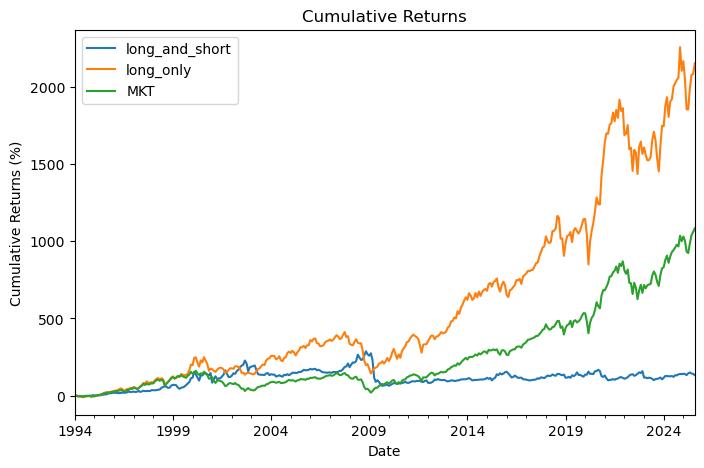

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
(100 * ((1 + temp[mom_names + ['MKT']].loc['1994':]).cumprod() -1 )).plot(ax=ax)
ax.set_ylabel('Cumulative Returns (%)')
ax.set_title('Cumulative Returns')

## 2.3 Is momentum just data mining or is it a robust strategy? 

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:  

long the top 1 decile and short the bottom 1 deciles, long the top 3 deciles and short the bottom 3 deciles, long the top 5 deciles and short the bottom 5 decile

(a) Compare all 3 construction by filling out the stats in the table below for the period 1994-2025

In [10]:
ls_1decile = mom_deciles['Hi PRIOR'] - mom_deciles['Lo PRIOR']
ls_3decile = mom_deciles.iloc[:,-3:].mean(axis = 1) - mom_deciles.iloc[:,:3].mean(axis = 1)
ls_5decile = mom_deciles.iloc[:,-5:].mean(axis = 1) - mom_deciles.iloc[:,:5].mean(axis = 1)

ls_names = ['mom_D1','mom_D3','mom_D5']
temp = ff_factors.copy()
temp[ls_names] = pd.concat([ls_1decile, ls_3decile, ls_5decile], axis=1)
summary = calc_summary_statistics(temp.loc["1994":, ls_names + ['UMD']], annual_factor=12, provided_excess_returns=True)[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', ls_names + ['UMD']]
summary['val_corr'] = temp.corr().loc['HML', ls_names + ['UMD']]
summary.style.format('{:.1%}')

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
mom_D1,7.4%,29.9%,24.8%,-127.1%,-36.5%,-40.3%
mom_D3,2.7%,19.3%,13.9%,-132.0%,-37.8%,-39.7%
mom_D5,1.6%,13.4%,11.6%,-140.8%,-36.1%,-39.1%
UMD,4.1%,16.6%,24.9%,-145.2%,-34.8%,-41.0%


(b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?  
Yes the long-short portfolio that takes the most extremes has higher return but it also has a higher volatility. We could expect the volatility to act differently though as taking on more winners (or losers) could diversify and hence lower volatility.

(c) Should AQR’s retail product consider using a 1-decile or 5-decile construction?  
I wouldn't recommend a 1 decile as it could have high turnover and hence higher fees for investors. Because of this the 5 decile is a good option in my opinion.

(d) Does r<sup>momD3</sup> have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.  
Fama french has higher return and lower vol. and a higher sharpe but they are somewhat similar. The difference is a decile construction can be biased by size or value whereas fama french accounts for this.

## Does implementing momentum require trading lots of small stocks– thus causing even larger trading costs?

(a) Fill out Table 4 over the sample 1994-2025.

In [11]:
mom_small = tercile_port['SMALL HiPRIOR'] - tercile_port['SMALL LoPRIOR']
mom_large = tercile_port['BIG HiPRIOR'] - tercile_port['BIG LoPRIOR']

mom_size_name = ['Small_stocks','Big_stocks']
temp = ff_factors.copy()
temp[mom_size_name] = pd.concat([mom_small, mom_large], axis=1)
summary = calc_summary_statistics(temp.loc["1994":, ['UMD'] + mom_size_name], annual_factor=12, provided_excess_returns=True)[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', ['UMD'] + mom_size_name]
summary['val_corr'] = temp.corr().loc['HML', ['UMD'] + mom_size_name]
summary.rename({'UMD':'All_stocks'}).style.format('{:.1%}')

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
All_stocks,4.1%,16.6%,24.9%,-145.2%,-34.8%,-41.0%
Small_stocks,6.2%,16.8%,36.9%,-181.3%,-34.1%,-39.3%
Big_stocks,2.1%,18.2%,11.4%,-85.5%,-32.2%,-38.9%


(b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?  
Yes the small stocks momentum portfolio has a sharpe ratio almost 3 times as high as the large stock momentum portfolio. The large stock momentum portfolio still have positive excess returns.

## 2.5 Conclusion

In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?  
- The product only takes long positions which leads it to have high correlation with the market and not be as diversfied compared to the fama-french momentum factor
- quarterly rebalancing could lead to tracking error from the benchmark index and fama french momentum factor as well